In [1]:
'''
训练Hybrid VAE，预测 28天死亡率及院内死亡率
'''
import os, sys
from datetime import datetime
import argparse
import pandas as pd
import json
import pickle
import joblib
import torch
from torchinfo import summary
import optuna
from optuna.visualization import (
    plot_parallel_coordinate,
    plot_param_importances,
    plot_contour,
    plot_slice,
    plot_optimization_history,
    plot_pareto_front,
)
import seaborn as sns
import plotly.graph_objects as go
sns.set_theme('paper')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold 

# 检测运行环境
IN_NOTEBOOK = None
def in_notebook():
    return 'IPKernelApp' in getattr(globals().get('get_ipython', lambda: None)(), 'config', {})
    
if in_notebook():
    IN_NOTEBOOK = True
    print('run in notebook')
    pd.set_option('display.max_columns', None)
    from IPython.display import clear_output, display
    notebook_dir = os.getcwd()
    src_path = os.path.abspath(os.path.join(notebook_dir, '..'))
    RUN_MODE = 'tuning' # reload: 重现study; tuning 搜索超参数
    N_TRIAL = 100
else:
    IN_NOTEBOOK = False
    print('run in script')
    src_path = os.path.abspath(os.path.dirname(os.path.dirname(__file__)))
    parser = argparse.ArgumentParser(description='')
    parser.add_argument('-n', metavar= 50, type=int, default=50,help='''optuna优化尝试次数''')
    sys_args = parser.parse_args()
    N_TRIAL = sys_args.n
    RUN_MODE = 'tuning' # 脚本模式只做tuing!

sys.path.append(src_path) if src_path not in sys.path else None
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

from src.utils import *
from src.model_utils import to_numpy, check_tensor
from src.metrix import cal_ci, format_ci
from src.setup import *
from risk_setup import *
from risk_model.HybridVAE import HybridVAEMultiTaskSklearn

set_random_seed(19960816)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'current device: {DEVICE}')
risk_hybrid_vae = f'{MODELS}/risk_models/Hybrid_VAE_model/'
os.makedirs(risk_hybrid_vae, exist_ok=True)

run in notebook
current device: cuda


In [2]:
df = pd.read_csv(f'{DATA}/imputed/MIMIC_IV_clean_imputed.tsv.gz', sep='\t', index_col='ID')
df = df.sample(frac=0.1) if IN_NOTEBOOK else df
features, _, _, outcomes = get_risk_model_features()
X, y = load_data(df, outcome_ix=0) # 这里加载了 28-d mortality 作为预测目标

# load multi-task y
y = df[outcomes].copy() 

# standardization of X
std_processor = StandardScaler()
X_array = std_processor.fit_transform(X)
X = pd.DataFrame(X_array, index=X.index, columns=X.columns)
joblib.dump(std_processor, f'{risk_hybrid_vae}/MIMIC_StandardScaler.joblib')

print(f'training data: {X.shape}')

training data: (2001, 31)


# Usage Example

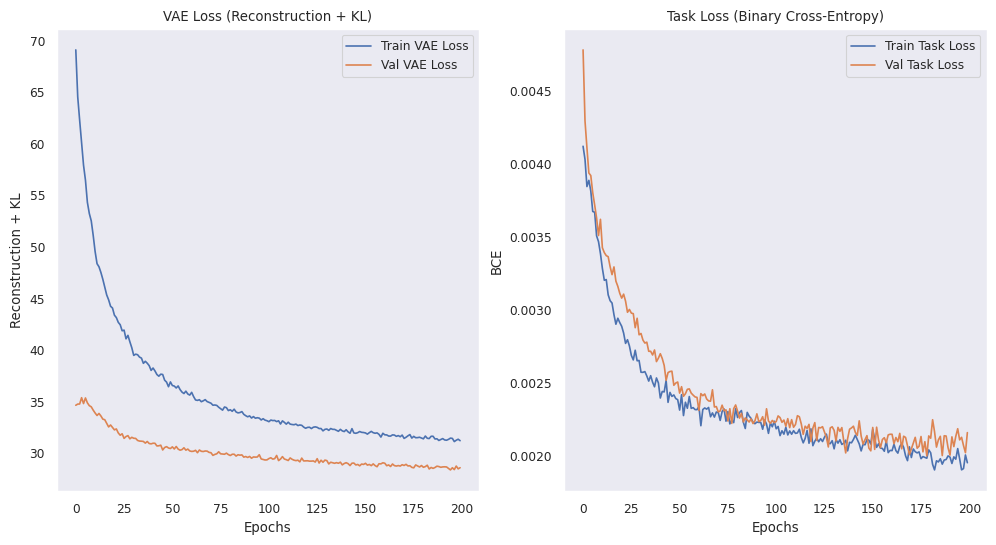

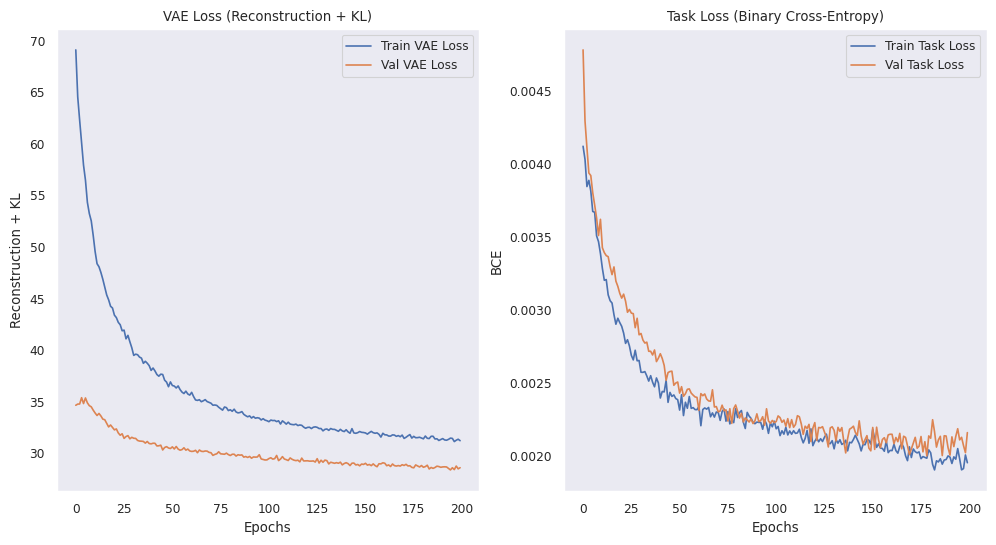

Training Progress:  13%|██              | 265/2000 [00:30<03:01,  9.57epoch/s, Train VAE Loss=30.6784, Val VAE Loss=28.4084, Train AUC=0.7266, Val AUC=0.7424]

In [ ]:
# if IN_NOTEBOOK:
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=19960816)
#     aucs_1 = []
#     aucs_2 = []
#     for i, (train_index, val_index) in enumerate(kf.split(X, y.iloc[:,0])):
#         # 划分训练集和验证集
#         X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#         y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#         model = HybridVAEMultiTaskSklearn(input_dim=X_train.shape[1],
#                                         task_count=y_train.shape[1],
#                                         layer_strategy='l',
#                                         vae_hidden_dim=50,
#                                         vae_depth=1,
#                                         vae_dropout_rate=0.3,
#                                         latent_dim=10,
#                                         predictor_hidden_dim=20,
#                                         predictor_depth=1,
#                                         task_hidden_dim=20,
#                                         task_depth=1,
#                                         predictor_dropout_rate=0.3,
#                                         vae_lr=1e-3,
#                                         vae_weight_decay=1e-3,
#                                         multitask_lr=1e-3,
#                                         multitask_weight_decay=1e-3,
#                                         alphas=None,
#                                         beta=1.0,
#                                         gamma_task=10000.0,
#                                         batch_size=500,
#                                         validation_split=0.2,
#                                         use_lr_scheduler=True,
#                                         lr_scheduler_factor=0.2,
#                                         lr_scheduler_patience=25,
#                                         use_batch_norm=True,
#                                         )

#         model = model.fit(X_train, y_train,
#                         epochs=2000, 
#                         early_stopping=True, 
#                         patience=100,
#                         verbose=2, 
#                         animate_monitor=True,
#                         plot_path=None,
#                         save_weights_path=None
#                         )

#         auc1, auc2 = model.score(X_val, y_val)
#         aucs_1.append(auc1)
#         aucs_2.append(auc2)
        
#     # assume t-distribution for 95% CI calculation
#     mean_auc_1, lower_1, upper_1 = cal_ci(aucs_1, alpha=0.05, method='t')
#     mean_auc_2, lower_2, upper_2 = cal_ci(aucs_2, alpha=0.05, method='t')
#     print(f'AUC of {outcomes[0]}: {format_ci(mean_auc_1, lower_1, upper_1, 3)}')
#     print(f'AUC of {outcomes[1]}: {format_ci(mean_auc_2, lower_2, upper_2, 3)}')
    
#     total_loss, recon_loss, kl_loss, task_loss = model.eval_loss(X_val, y_val)
#     print(f'Losses on last fold: {total_loss=:.4f}, {recon_loss=:.4f}, {kl_loss=:.4f}, {task_loss=:.4f}')
#     print(summary(model, input_size=(model.batch_size, X.shape[1])))

In [ ]:
# AUC of 28d_mortality: 0.740 (0.715 - 0.766)
# AUC of in_hospital_mortality: 0.745 (0.717 - 0.772)

In [4]:
# AUC of 28d_mortality: 0.764 (0.726 - 0.803)
# AUC of in_hospital_mortality: 0.767 (0.734 - 0.799)

# Hyper Parameter Tuning

In [ ]:
if RUN_MODE=='tuning':

    def objective(trial):
        try:
            # 定义需要调优的超参数范围
            # network structure
            layer_strategy = trial.suggest_categorical("layer_strategy", ['c', 'l', 'g'])
            vae_hidden_dim = trial.suggest_int("vae_hidden_dim", 20, 200, step=10)
            vae_depth = trial.suggest_int("vae_depth", 0, 3, step=1)
            vae_dropout_rate = trial.suggest_float("vae_dropout_rate", 0.05, 0.5, step=0.05)
            latent_dim = trial.suggest_int("latent_dim", 5, 15, step=1)
            predictor_hidden_dim = trial.suggest_int("predictor_hidden_dim", 10, 100, step=10)
            predictor_depth = trial.suggest_int("predictor_depth", 0, 2, step=1)
            task_hidden_dim =  trial.suggest_int("task_hidden_dim", 10, 30, step=5)
            task_depth = trial.suggest_int("task_depth", 0, 2, step=1)
            predictor_dropout_rate = trial.suggest_float("predictor_dropout_rate", 0.05, 0.5, step=0.05)
            # learning and normalization
            vae_lr = trial.suggest_float("vae_lr", 1e-5, 1e-3, log=True)
            vae_weight_decay = trial.suggest_float("vae_weight_decay", 1e-5, 1e-2, log=True)
            multitask_lr = trial.suggest_float("multitask_lr", 1e-5, 1e-3, log=True)
            multitask_weight_decay = trial.suggest_float("multitask_weight_decay", 1e-5, 1e-2, log=True)
            beta = trial.suggest_float("beta", 1.0, 5.0, step=0.1)
            gamma_task = trial.suggest_float("gamma_task", 1.0, 100000, log=True) 
            batch_size = trial.suggest_int("batch_size", 200, 1000, step=100)
            validation_split = trial.suggest_categorical("validation_split", [0.2, 0.3, 0.4])
            use_lr_scheduler = trial.suggest_categorical("use_lr_scheduler", [True, False])
            lr_scheduler_factor = trial.suggest_categorical("lr_scheduler_factor", [0.1, 0.2])
            fit_patience = 100
            lr_scheduler_patience = trial.suggest_categorical("lr_scheduler_patience", [int(fit_patience/2), int(fit_patience/3), int(fit_patience/4),])
            use_batch_norm = trial.suggest_categorical("use_batch_norm", [True, False])
            # 初始化模型
            model = HybridVAEMultiTaskSklearn(input_dim=X.shape[1],
                                            task_count=y.shape[1],
                                            layer_strategy=layer_strategy,
                                            vae_hidden_dim=vae_hidden_dim,
                                            vae_depth=vae_depth,
                                            vae_dropout_rate=vae_dropout_rate,
                                            latent_dim=latent_dim,
                                            predictor_hidden_dim=predictor_hidden_dim,
                                            predictor_depth=predictor_depth,
                                            task_hidden_dim=task_hidden_dim,
                                            task_depth=task_depth,
                                            predictor_dropout_rate=predictor_dropout_rate,
                                            vae_lr=vae_lr,
                                            vae_weight_decay=vae_weight_decay,
                                            multitask_lr=multitask_lr,
                                            multitask_weight_decay=multitask_weight_decay,
                                            alphas=None,
                                            beta=beta,
                                            gamma_task=gamma_task,
                                            batch_size=batch_size,
                                            validation_split=validation_split,
                                            use_lr_scheduler=use_lr_scheduler,
                                            lr_scheduler_factor=lr_scheduler_factor,
                                            lr_scheduler_patience=lr_scheduler_patience,
                                            use_batch_norm=use_batch_norm,
                                            )
            # 实现交叉验证
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=19960816)
            aucs_1 = []
            aucs_2 = []
            recon_losses = []
            vae_losses = []

            for i, (train_index, val_index) in enumerate(kf.split(X, y.iloc[:,0])): # stratified by primary outcome
                # 划分训练集和验证集
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                
                # 训练模型
                model.fit(X_train, y_train,
                            epochs=2000, 
                            early_stopping=True, 
                            patience=fit_patience,
                            verbose=1, 
                            animate_monitor=False,
                            plot_path=None,
                            save_weights_path=None)
                
                # 验证模型并记录分数
                auc1, auc2 = model.score(X_val, y_val)  # 默认AUC
                total_loss, recon_loss, kl_loss, task_loss = model.eval_loss(X_val, y_val)
                vae_loss = recon_loss + model.beta * kl_loss

                aucs_1.append(auc1)
                aucs_2.append(auc2)
                recon_losses.append(recon_loss)
                vae_losses.append(vae_loss)

            # 返回平均交叉验证分数（负均方误差）
            return np.mean(aucs_1), np.mean(aucs_2), np.mean(vae_losses), np.mean(recon_losses)
        except Exception as e:
            print(f"Trial failed with error: {e}")
            return -np.inf, -np.inf, np.inf, np.inf


    # 日志功能：设置 Optuna 的日志级别
    # optuna.logging.set_verbosity(optuna.logging.INFO)

    # 实时打印当前最佳结果
    def trial_callback(study, trial):
        is_multiobjective = len(study.directions) > 1  # 判断是否多目标优化

        if is_multiobjective:
            pareto_front = study.best_trials  # 获取 Pareto 前沿解

            if IN_NOTEBOOK:
                clear_output(wait=True)  # 清除之前的输出
                df_trials = study.trials_dataframe()  # 获取当前的试验数据
                display(df_trials)  # 动态显示最新的 dataframe

                # 打印 Pareto 前沿解的信息
                print(f"Number of Pareto optimal solutions: {len(pareto_front)}")
                for i, pareto_trial in enumerate(pareto_front):
                    print(f"Pareto solution {i}: Values {pareto_trial.values}, Params {pareto_trial.params}")
            else:
                best_trial = pareto_front[0]  # 选择首选 Pareto 前沿解
                print(
                    f"Trial {trial.number}/{N_TRIAL} finished with value: {trial.values} and parameters: {trial.params} | "
                    f"Current best value: {best_trial.values} and parameters: {best_trial.params} | "
                    f"Number of Pareto optimal solutions: {len(pareto_front)}"
                )
        else:
            if IN_NOTEBOOK:
                clear_output(wait=True)  # 清除之前的输出
                df_trials = study.trials_dataframe()  # 获取当前的试验数据
                display(df_trials)  # 动态显示最新的 dataframe

                # 打印当前最优解的信息
                print(f"Current best value: {study.best_value}")
                print(f"Current best parameters: {study.best_params}")
                print(f"Current best trial: {study.best_trials}")
            else:
                print(
                    f"Trial {trial.number}/{N_TRIAL} finished with value: {trial.value} and parameters: {trial.params} | "
                    f"Current best value: {study.best_value} and parameters: {study.best_params}"
                )
                
    # 使用 Optuna 优化
    study = optuna.create_study(directions=["maximize", "maximize", "minimize", 'minimize'], sampler=optuna.samplers.NSGAIISampler(seed=20221021))  # 或 "minimize"，取决于评分标准
    study.optimize(objective, n_trials=N_TRIAL, callbacks=[trial_callback])

    # 保存实验结果
    with open(f"{risk_hybrid_vae}/optuna_study.pkl", "wb") as f:
        print('调参结束，正在保存optuna调参试验结果')
        pickle.dump(study, f)

    # 获取 Pareto 前沿解
    pareto_front = study.best_trials
    print("Pareto Front Solutions:")
    for trial in pareto_front:
        print(f"Trial {trial.number}: Values {trial.values}, Params {trial.params}")

    # 保存 Pareto 解到文件
    pareto_data = [
        {"trial_number": trial.number, "values": trial.values, "params": trial.params}
        for trial in pareto_front
    ]
    with open(f"{risk_hybrid_vae}/pareto_solutions.json", "w") as f:
        json.dump(pareto_data, f)


    # 保存完整调参历史为 xlsx 文件
    df_trials = study.trials_dataframe()
    df_trials.to_excel(f"{risk_hybrid_vae}/tuning_history.xlsx", index=False)

[I 2024-12-08 23:10:16,169] A new study created in memory with name: no-name-e4e66a95-96a3-4b77-9ad1-e5900bfa45cd
Training Progress:  32%|█▎  | 634/2000 [01:30<03:14,  7.03epoch/s, Train VAE Loss=35.9333, Val VAE Loss=30.3321, Train Task Loss=0.0055, Val Task Loss=0.0077]


Early stopping triggered due to no improvement in both VAE and task losses.


Training Progress:   7%|▎   | 146/2000 [00:20<04:23,  7.04epoch/s, Train VAE Loss=44.8032, Val VAE Loss=30.4330, Train Task Loss=0.0056, Val Task Loss=0.0076]

# Training with best params

In [ ]:
if RUN_MODE=='tuning':
    pass

elif RUN_MODE=='reload':
    with open(f"{risk_hybrid_vae}/optuna_study.pkl", "rb") as f:
        print('正在加载指定optuna调参试验结果')
        study = pickle.load(f)
        
# 使用一个 Pareto 最优解重新初始化模型
pareto_front = study.best_trials
best_trial = pareto_front[0] # 选择第一个 Pareto 解
best_params = best_trial.params

# 使用最佳参数重新初始化模型
best_model = HybridVAEMultiTaskSklearn(input_dim=X.shape[1], task_count=y.shape[1], **best_params)

# 训练最佳模型
print('使用最佳参数进行内部验证估计误差')
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=19960816)
aucs_1 = []
aucs_2 = []
for i, (train_index, val_index) in enumerate(kf.split(X, y.iloc[:,0])):
    # 划分训练集和验证集
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = HybridVAEMultiTaskSklearn(input_dim=X_train.shape[1],
                                    task_count=y_train.shape[1],
                                    layer_strategy='l',
                                    vae_hidden_dim=50,
                                    vae_depth=1,
                                    vae_dropout_rate=0.3,
                                    latent_dim=10,
                                    predictor_hidden_dim=20,
                                    predictor_depth=1,
                                    task_hidden_dim=20,
                                    task_depth=1,
                                    predictor_dropout_rate=0.3,
                                    vae_lr=1e-3,
                                    vae_weight_decay=1e-3,
                                    multitask_lr=1e-3,
                                    multitask_weight_decay=1e-3,
                                    alphas=None,
                                    beta=1.0,
                                    gamma_task=10000.0,
                                    batch_size=256,
                                    validation_split=0.2,
                                    use_lr_scheduler=True,
                                    lr_scheduler_factor=0.2,
                                    lr_scheduler_patience=25,
                                    use_batch_norm=True,
                                    )

    model = model.fit(X_train, y_train,
                    epochs=2000, 
                    early_stopping=True, 
                    patience=100,
                    verbose=2, 
                    animate_monitor=True,
                    plot_path=None,
                    save_weights_path=None
                    )

    auc1, auc2 = model.score(X_val, y_val)
    aucs_1.append(auc1)
    aucs_2.append(auc2)

# assume t-distribution for 95% CI calculation
mean_auc_1, lower_1, upper_1 = cal_ci(aucs_1, alpha=0.05, method='t')
mean_auc_2, lower_2, upper_2 = cal_ci(aucs_2, alpha=0.05, method='t')
print(f'AUC of {outcomes[0]}: {format_ci(mean_auc_1, lower_1, upper_1, 3)}')
print(f'AUC of {outcomes[1]}: {format_ci(mean_auc_2, lower_2, upper_2, 3)}')

total_loss, recon_loss, kl_loss, task_loss = model.eval_loss(X_val, y_val)
print(f'Losses on last fold: {total_loss=:.4f}, {recon_loss=:.4f}, {kl_loss=:.4f}, {task_loss=:.4f}')
print(summary(model, input_size=(model.batch_size, X.shape[1])))

print('使用最佳参数在全集上训练模型 （准备外部验证）')
best_model.fit(X, y,
                epochs=2000, 
                early_stopping=True, 
                patience=200,
                verbose=2, 
                animate_monitor=True,
                plot_path=risk_hybrid_vae,
                save_weights_path=risk_hybrid_vae)

print(f'最终AUC: {best_model.score(X, y)}')

In [ ]:
# 绘制不同的图表
target_args_1 = dict(target = lambda t: -t.values[0], target_name="AUC-primary")
target_args_2 = dict(target = lambda t: -t.values[1], target_name="AUC-secondary")
target_args_3 = dict(target = lambda t: -t.values[2], target_name="VAE loss")
target_args_4 = dict(target = lambda t: -t.values[3], target_name="Reconstruction MSE")
targets_args = dict(targets = lambda t: [t.values[0], -t.values[2]], target_names=["AUC", "VAE loss"])

# 并行坐标图
parallel_coordinate_fig = plot_parallel_coordinate(study, **target_args_1)
parallel_coordinate_fig.update_layout(width=800, height=600)
parallel_coordinate_fig.show() if IN_NOTEBOOK else None
parallel_coordinate_fig.write_image(f"{risk_hybrid_vae}/parallel_coordinate_fig.svg", format='svg', scale=2, width=700, height=500) if not IN_NOTEBOOK else None

# 参数重要性图
param_importance_fig = plot_param_importances(study, **target_args_1)
param_importance_fig.update_layout(width=800, height=600)
param_importance_fig.show() if IN_NOTEBOOK else None
param_importance_fig.write_image(f"{risk_hybrid_vae}/param_importance_fig.svg", format='svg', scale=2, width=700, height=500) if not IN_NOTEBOOK else None

# 平行曲面图
contour_fig = plot_contour(study, **target_args_1)
contour_fig.update_layout(width=1200, height=1200)
contour_fig.show() if IN_NOTEBOOK else None
contour_fig.write_image(f"{risk_hybrid_vae}/contour_fig.svg", format='svg', scale=2, width=1200, height=1200) if not IN_NOTEBOOK else None

# 超参数分布图
slice_fig = plot_slice(study, **target_args_1)
slice_fig.show() if IN_NOTEBOOK else None
slice_fig.write_image(f"{risk_hybrid_vae}/slice_fig.svg", format='svg', scale=2, width=2500, height=400) if not IN_NOTEBOOK else None

# 优化历史图
optimization_history_fig = plot_optimization_history(study, **target_args_1)
optimization_history_fig.update_layout(width=700, height=500)
optimization_history_fig.show() if IN_NOTEBOOK else None
optimization_history_fig.write_image(f"{risk_hybrid_vae}/optimization_history_fig.svg", format='svg', scale=2, width=700, height=500) if not IN_NOTEBOOK else None

# Pareto 前沿图（仅适用于多目标优化）
if len(study.directions) > 1:
    pareto_fig = plot_pareto_front(study, **targets_args)
    pareto_fig.update_layout(width=1200, height=800)
    pareto_fig.show() if IN_NOTEBOOK else None
    pareto_fig.write_image(f"{risk_hybrid_vae}/pareto_fig.svg", format='svg', scale=2, width=1200, height=1200) if not IN_NOTEBOOK else None
